<a href="https://colab.research.google.com/github/RG2806/ai_spotle/blob/master/level3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/RG2806/ai_spotle.git

Cloning into 'ai_spotle'...
remote: Enumerating objects: 43, done.
remote: Counting objects: 100% (43/43), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 4109 (delta 31), reused 34 (delta 29), pack-reused 4066
Receiving objects: 100% (4109/4109), 38.50 MiB | 10.00 MiB/s, done.
Resolving deltas: 100% (52/52), done.
Checking out files: 100% (4086/4086), done.


In [2]:
import pandas as pd
import os
#combine all files in the lis
df = pd.concat([pd.read_json("/content/ai_spotle/aithon2020_level_3/"+f) for c,f in enumerate(os.listdir("/content/ai_spotle/aithon2020_level_3/")) ])

In [3]:
df.shape

(496448, 4)

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from sklearn.model_selection import train_test_split,KFold,StratifiedKFold
from sklearn import model_selection, preprocessing, metrics, svm, ensemble
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.svm import SVC, NuSVC, LinearSVC
from sklearn.model_selection import GridSearchCV
import re
from bs4 import BeautifulSoup
from nltk.tokenize import WordPunctTokenizer
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [5]:
tok = WordPunctTokenizer()
lemma = WordNetLemmatizer()
# patterns to remove html tags numbers and special Characters
pat1 = r'@[A-Za-z0-9_]+'
pat2 = r'https?://[^ ]+'
combined_pat = r'|'.join((pat1, pat2))
negations_dic = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",
                "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
                "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
                "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
                "mustn't":"must not"}
shortcuts = {'u': 'you', 'y': 'why', 'r': 'are', 'doin': 'doing', 'hw': 'how', 'k': 'okay', 'm': 'am', 'b4': 'before',
            'idc': "i do not care", 'ty': 'thankyou', 'wlcm': 'welcome', 'bc': 'because', '<3': 'love', 'xoxo': 'love',
            'ttyl': 'talk to you later', 'gr8': 'great', 'bday': 'birthday', 'awsm': 'awesome', 'gud': 'good', 'h8': 'hate',
            'lv': 'love', 'dm': 'direct message', 'rt': 'retweet', 'wtf': 'hate', 'idgaf': 'hate',
             'irl': 'in real life', 'yolo': 'you only live once'}
neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')
shortcuts_pattern = re.compile(r'\b(' + '|'.join(shortcuts.keys()) + r')\b')
def clean_text(text):
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    try:
        bom_removed = souped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        bom_removed = souped
    stripped = re.sub(combined_pat, '', bom_removed)#for removing patterns like #,@ and punctuation
    lower_case = stripped.lower()
    neg_handled = neg_pattern.sub(lambda x: negations_dic[x.group()], lower_case)
    shortcuts_handled = shortcuts_pattern.sub(lambda x: shortcuts[x.group()],neg_handled)
    letters_only = re.sub("[^a-zA-Z]", " ", shortcuts_handled)
    # During the letters_only process two lines above, it has created unnecessay white spaces,
    # I will tokenize and join together to remove unneccessary white spaces
    words = [x for x  in tok.tokenize(letters_only) if len(x) > 1]
    lemmated_words = [lemma.lemmatize(word) for word in words]
    return (" ".join( lemmated_words)).strip()

In [6]:
df['cleaned_tweets'] = df['text'].apply(lambda x: clean_text(x))

In [7]:
df.head()

,text,location,date,time,cleaned_tweets
0,@MattHancock Why do people not need to self is...,IN,Sep 22,08:59:42,why do people not need to self isolate or wear...
1,When you think way back before the first lockd...,"South West, England, UK",Sep 22,08:59:22,when you think way back before the first lockd...
2,@blessingswork @Dr_Uditraj @INCIndia Go and go...,United Kingdom,Sep 22,08:59:21,go and google unemployment rate before corona ...
3,@BasilioCC @franckluyz_2012 @_fels1 @AgapetusW...,,Sep 22,08:58:11,what we need is to have proper psychological p...
4,"@ABSCBNNews ""You cannot exterminate COVID."" \n...","Nairobi, Kenya",Sep 22,08:57:19,you cannot exterminate covid why because coron...


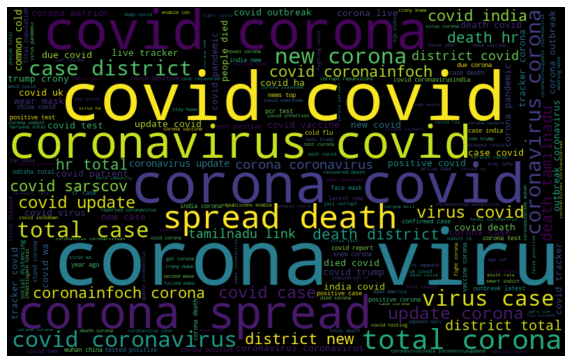

In [8]:
all_words = ' '.join([text for text in df['cleaned_tweets']])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [9]:
from textblob import TextBlob

In [10]:
df['polarity']=df['cleaned_tweets'].apply(lambda x: TextBlob(x).sentiment[0])
df['subjectivity']=df['cleaned_tweets'].apply(lambda x: TextBlob(x).sentiment[1])
df.head()

,text,location,date,time,cleaned_tweets,polarity,subjectivity
0,@MattHancock Why do people not need to self is...,IN,Sep 22,08:59:42,why do people not need to self isolate or wear...,0.000000,0.000000
1,When you think way back before the first lockd...,"South West, England, UK",Sep 22,08:59:22,when you think way back before the first lockd...,0.078241,0.332870
2,@blessingswork @Dr_Uditraj @INCIndia Go and go...,United Kingdom,Sep 22,08:59:21,go and google unemployment rate before corona ...,-0.211111,0.533333
3,@BasilioCC @franckluyz_2012 @_fels1 @AgapetusW...,,Sep 22,08:58:11,what we need is to have proper psychological p...,0.000000,0.100000
4,"@ABSCBNNews ""You cannot exterminate COVID."" \n...","Nairobi, Kenya",Sep 22,08:57:19,you cannot exterminate covid why because coron...,-0.300000,0.833333


In [14]:
def sentiment(x):
    if x>0:
       return 'positive'
    if x<0:
      return 'negative'
    return 'neutral' 
df['analysis'] = df['polarity'].apply(sentiment)

In [15]:
df.head()

,text,location,date,time,cleaned_tweets,polarity,subjectivity,analysis
0,@MattHancock Why do people not need to self isolate or wear masks after a flu shot Matt? @simondolan @Francis_Hoar @KateShemirani #Covid_19 #COVID19 #coronavirus #Corona https://t.co/SvT7kWBSby,IN,Sep 22,08:59:42,why do people not need to self isolate or wear mask after flu shot matt covid covid coronavirus corona,0.000000,0.000000,neutral
1,"When you think way back before the first lockdown supermarket workers continued to handle produce without protection all the way throughout with no adverse effects &amp; rise in catching corona/ covid , not one supermarket closed down due to infections?","South West, England, UK",Sep 22,08:59:22,when you think way back before the first lockdown supermarket worker continued to handle produce without protection all the way throughout with no adverse effect rise in catching corona covid not one supermarket closed down due to infection,0.078241,0.332870,positive
2,@blessingswork @Dr_Uditraj @INCIndia Go and google unemployment rate before corona and plz dont even try to blame only corona its govt failure . We are nu 2 in covid patients ye kiska failure hai?,United Kingdom,Sep 22,08:59:21,go and google unemployment rate before corona and plz dont even try to blame only corona it govt failure we are nu in covid patient ye kiska failure hai,-0.211111,0.533333,negative
3,"@BasilioCC @franckluyz_2012 @_fels1 @AgapetusWamalwa @AnneMbugua16 @ayogo_do @busolomareezz @chothep @LydiahKinyanju4 @LucyM50876035 @MoriangoJr @SolomonKarori2 2/2 what we need is to have proper psychological preparedness for reopening but nothing to fear. In the villages, football is being played from dawn to dusk with no Covid-19 regulations observed, just as it came Corona has gone",,Sep 22,08:58:11,what we need is to have proper psychological preparedness for reopening but nothing to fear in the village football is being played from dawn to dusk with no covid regulation observed just a it came corona ha gone,0.000000,0.100000,neutral
4,"@ABSCBNNews ""You cannot exterminate COVID."" \nWhy? \nBecause Corona Virus is one of the cause of common cold(sipon). The only answer to stopping this pandemic: Autopsy, Microbiological Report &amp; Differential diagnosis.","Nairobi, Kenya",Sep 22,08:57:19,you cannot exterminate covid why because corona virus is one of the cause of common cold sipon the only answer to stopping this pandemic autopsy microbiological report differential diagnosis,-0.300000,0.833333,negative


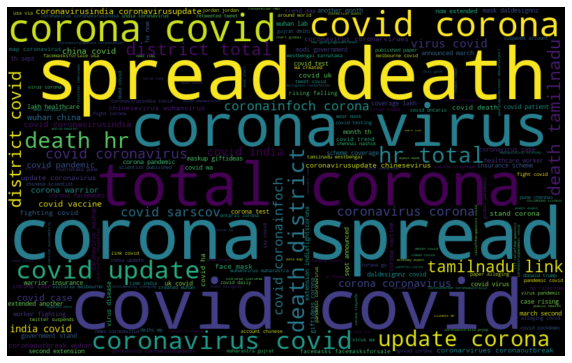

In [18]:
normal_words =' '.join([text for text in df['cleaned_tweets'][df['analysis'] == 'neutral']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [ ]:
df1=df[df.analysis=='positive']